# Trabajo Práctico 2: Modelo de Lenguaje

### Francisco Mendizábal (61454)
### Agustin Vazquez (61420)
### Sebastian N. Herrera (61457)


keras.io/api/keras_nlp/metrics/perplexity

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
from collections import Counter
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import pad_sequences
import numpy as np
import gensim
import os, re, csv, math, codecs
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

La forma de tomar el set de entrenamiento consistió en primero utilizar el texto de "Frankenstein" y construir un vocabulario con las N palabras más probables.

Luego, para cada una de esas palabras, se tomaron las M palabras anteriores, reemplazando por UNK las palabras de x_train que no se encuentran en el diccionario. De esta manera, las palabras UNK se utilizan para entrenar la red, de forma que la estructura de la oración se mantenga. Sin embargo, no notamos diferencias respecto a solo tomar en x_train las palabras dentro del diccionario.

Algo que si influyó considerablemente en el resultado, fue eliminar los UNK de y_train, ya que debido a que el diccionario fue reducido, su probabilidad de ocurrencia era bastante alta, impidiendo predecir palabras.

In [ ]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('/content/drive/My Drive/Redes_2/wiki-news-300d-1M.vec', encoding='utf-8')
for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...
found 999995 word vectors


In [ ]:
book = open('/content/drive/My Drive/Redes_2/Frankenstein.txt').read()

In [ ]:
nwords = 500
#token = Tokenizer(num_words=nwords, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n’‘“”—', lower=True, split=' ', char_level=False, document_count=0)
token = Tokenizer(num_words=nwords, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n’‘“”—', lower=True, split=' ', char_level=False, oov_token="UNK", document_count=0)

In [ ]:
words = text_to_word_sequence(book, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n’‘“”—')

In [ ]:
token.fit_on_texts(words)

In [ ]:
# Creo el diccionario con las n palabras mas probables
sorted_keys = sorted(token.word_counts, key=token.word_counts.get, reverse=True)[:nwords]
word_distribution = sorted(list(token.word_docs.values()), reverse=True)[:nwords]
word_distribution = word_distribution / np.sum(word_distribution)
dictionary = dict((key, value+2) for (value, key) in enumerate(sorted_keys))
reverse_dictionary = dict([(value+2, key) for (value, key) in enumerate(dictionary.keys())])

In [ ]:
print(sorted_keys[:5])
print(word_distribution[:5])
print(dictionary)
print(reverse_dictionary)

['the', 'and', 'i', 'of', 'to']
[0.07616038 0.05404228 0.05175419 0.04797705 0.03802571]
{'the': 2, 'and': 3, 'i': 4, 'of': 5, 'to': 6, 'my': 7, 'a': 8, 'in': 9, 'was': 10, 'that': 11, 'me': 12, 'but': 13, 'had': 14, 'with': 15, 'he': 16, 'you': 17, 'which': 18, 'it': 19, 'his': 20, 'as': 21, 'not': 22, 'for': 23, 'by': 24, 'on': 25, 'this': 26, 'from': 27, 'her': 28, 'have': 29, 'be': 30, 'when': 31, 'at': 32, 'were': 33, 'is': 34, 'she': 35, 'your': 36, 'him': 37, 'an': 38, 'they': 39, 'so': 40, 'one': 41, 'all': 42, 'could': 43, 'will': 44, 'if': 45, 'been': 46, 'their': 47, 'would': 48, 'are': 49, 'or': 50, 'we': 51, 'who': 52, 'no': 53, 'more': 54, 'now': 55, 'these': 56, 'should': 57, 'yet': 58, 'some': 59, 'before': 60, 'man': 61, 'myself': 62, 'father': 63, 'what': 64, 'them': 65, 'am': 66, 'upon': 67, 'our': 68, 'into': 69, 'its': 70, 'only': 71, 'did': 72, 'do': 73, 'life': 74, 'than': 75, 'every': 76, 'then': 77, 'first': 78, 'might': 79, 'own': 80, 'shall': 81, 'eyes': 82, 

Text(0.5, 1.0, 'Distribución de Palabras')

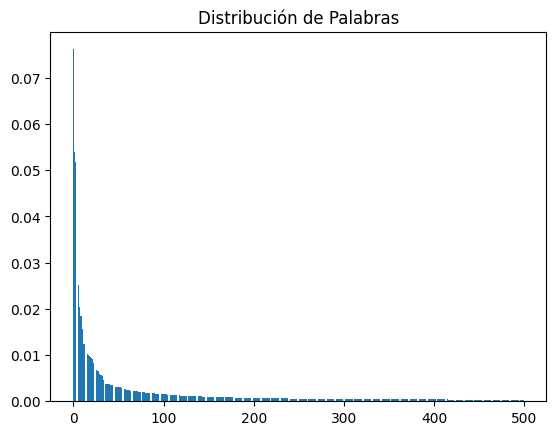

In [ ]:
plt.bar(np.arange(0, nwords), word_distribution)
plt.title('Distribución de Palabras')

### Embeddings con UNK

In [ ]:
wSize = 20
texts = []
stride = 1

# Genero secuencias de texto con el stride correspondiente
for i in range(0, len(words)-wSize, stride):
    aux:str = ''
    for j in range(i, i+wSize):
        aux += words[j]
        aux += ' '
    texts.append(aux)

In [ ]:
texts[:5]

['letter 1 to mrs saville england st petersburgh dec 11th 17 you will rejoice to hear that no disaster has ',
 '1 to mrs saville england st petersburgh dec 11th 17 you will rejoice to hear that no disaster has accompanied ',
 'to mrs saville england st petersburgh dec 11th 17 you will rejoice to hear that no disaster has accompanied the ',
 'mrs saville england st petersburgh dec 11th 17 you will rejoice to hear that no disaster has accompanied the commencement ',
 'saville england st petersburgh dec 11th 17 you will rejoice to hear that no disaster has accompanied the commencement of ']

In [ ]:
# Me quedo solamente con las secuencias que permiten predecir palabras en el diccionario
train_texts = []

# Palabras que se deben predecir
y_train_words = []

for i in range(wSize, len(texts)):
    if words[i] in dictionary.keys():
        train_texts.append(texts[i-wSize])
        y_train_words.append(words[i])

# Indices que se deben predecir
y_train = [dictionary[word] for word in y_train_words]

In [ ]:
train_texts[:5]

['1 to mrs saville england st petersburgh dec 11th 17 you will rejoice to hear that no disaster has accompanied ',
 'mrs saville england st petersburgh dec 11th 17 you will rejoice to hear that no disaster has accompanied the commencement ',
 'saville england st petersburgh dec 11th 17 you will rejoice to hear that no disaster has accompanied the commencement of ',
 'st petersburgh dec 11th 17 you will rejoice to hear that no disaster has accompanied the commencement of an enterprise ',
 'petersburgh dec 11th 17 you will rejoice to hear that no disaster has accompanied the commencement of an enterprise which ']

In [ ]:
# Secuencias de palabras que permiten predecir una palabra del diccionario
x_train_words = [text_to_word_sequence(text, lower=False) for text in train_texts]

# Secuencias de indices que permiten predecir una palabra del diccionario (por ahora no)
x_train = token.texts_to_sequences(train_texts)

In [ ]:
# Para aplicar mask_zero
#x_train = [[x if x!=1 else 0 for x in x_train[i]] for i in range(len(x_train))]

In [ ]:
print(len(x_train_words))
print(x_train_words[:5])
print(np.array(x_train[:5]))

55044
[['1', 'to', 'mrs', 'saville', 'england', 'st', 'petersburgh', 'dec', '11th', '17', 'you', 'will', 'rejoice', 'to', 'hear', 'that', 'no', 'disaster', 'has', 'accompanied'], ['mrs', 'saville', 'england', 'st', 'petersburgh', 'dec', '11th', '17', 'you', 'will', 'rejoice', 'to', 'hear', 'that', 'no', 'disaster', 'has', 'accompanied', 'the', 'commencement'], ['saville', 'england', 'st', 'petersburgh', 'dec', '11th', '17', 'you', 'will', 'rejoice', 'to', 'hear', 'that', 'no', 'disaster', 'has', 'accompanied', 'the', 'commencement', 'of'], ['st', 'petersburgh', 'dec', '11th', '17', 'you', 'will', 'rejoice', 'to', 'hear', 'that', 'no', 'disaster', 'has', 'accompanied', 'the', 'commencement', 'of', 'an', 'enterprise'], ['petersburgh', 'dec', '11th', '17', 'you', 'will', 'rejoice', 'to', 'hear', 'that', 'no', 'disaster', 'has', 'accompanied', 'the', 'commencement', 'of', 'an', 'enterprise', 'which']]
[[  0   6   0   0 418   0   0   0   0   0  17  44   0   6 459  11  53   0
  129   0]
 [  

In [ ]:
print(len(y_train_words))
print(y_train_words[:5])
print(np.array(y_train[:5]))

55044
['the', 'of', 'an', 'which', 'you']
[ 2  5 38 18 17]


In [ ]:
embed_dim = 300
embedding_matrix = np.zeros([nwords, embed_dim])
for word, idx in dictionary.items():
    if idx < nwords and word in embeddings_index:
        embedding_matrix[idx,:] = embeddings_index[word]

## Redes

Se probaron una red LTSM, una simple RNN, una CNN y una GRU. Si bien ninguna tuvo una gran performance, notamos que el mejor resultado se obtiene con LTSM, analizando los resultados obtenidos al realizar las predicciones de texto con distintas temperaturas.

Se probó modificar parametros adicionales, como la inserción o eliminación de la capa bidireccional, los mecanismos de attention y/o repeated attention, y agregar mask_zero. Se probo diferentes tipos de activación dentro de las limitaciones de hardware disponible (como usar tanh en LSTM ya que de otra manera perdemos el uso de la GPU proporcionada por colab).
El beneficio casi nulo de hacer estas cosas frente a los tiempos de entrenamiento, nos llevo a hacer una red simple que se pudiera replicar en todos los casos. Se tomo de base el siguiente video para la confección de la misma y la idea de trabajo: https://youtu.be/ZMudJXhsUpY?si=eHjODJ7vITktnRJW.
Pese a las numerosas modificaciones aplicadas sobre el modelo, ninguno de los casos se observaron diferencias notables, probablemente debido a la baja performance de la red.
El verdadero beneficio se encontro al eliminar restricciones impuestas al modelo, como el DropoutRate o el EarlyStopping; al permitir que nuestro modelo overfitee obtiene mejores resultados sobre las predicciones realizadas mas adelante.

Cabe destacar que al overfittear cualquiera de las redes los resultados mejoran, lo cual tiene sentido pues se empiezan a imitar oraciones textuales del texto original, siempre y cuando las palabras a predecir se encuentren en el vocabulario.

Medimos la perplejidad de cada una de las redes utilizando frases del propio entrenamiento, logrando resultados demasiado altos cuando la red no está overfitteada. Estos resultados mejoraron notablemente al retirar los UNK (palabras desconocidas por el diccionario de nuestra red) de los elementos a evaluar, error que estabamos cometiendo en un principio pero que se identifico y corrigio de manera exitosa.

### LTSM

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding, Conv1D, MaxPooling1D, BatchNormalization, GlobalMaxPooling1D, Dropout, Dense, Lambda, MaxPooling1D, Input, Concatenate, SimpleRNN, Dot, RepeatVector, TimeDistributed, Multiply, Lambda, Flatten, Activation, GRU, Reshape, Bidirectional, LSTM
from keras.models import Sequential, Model
from keras import optimizers
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.activations import softmax
import keras.backend as K
from keras.utils import plot_model

In [ ]:
value_dim=100
K.clear_session()
def softMaxOverTime(x):
    return softmax(x, axis=1)

nb_words = nwords
num_filters = 64
input_layer = Input(shape=(wSize,))
embedding_layer = Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=wSize, trainable=False, mask_zero=True)(input_layer)

# lstm_out=Bidirectional(LSTM(value_dim, return_sequences=True))(embedding_layer)
# lstm_out=Bidirectional(LSTM(value_dim, return_sequences=True))(lstm_out)
lstm_out = Bidirectional(LSTM(value_dim, return_sequences=True, activation="tanh"), merge_mode="sum")(embedding_layer)
#lstm_out = Bidirectional(LSTM(value_dim, return_sequences=True, activation="tanh"), merge_mode="sum")(lstm_out)  # Si se cambia la funcion de activacion, no usa la GPU

ulog_attention = Dense(1, activation="linear")(lstm_out)
attention=Activation(softMaxOverTime)(ulog_attention)
#repeated_attention = TimeDistributed(RepeatVector(value_dim))(attention)
#repeated_attention = Reshape([wSize, value_dim])(repeated_attention)
#weighted_embeddings = Multiply()([repeated_attention, lstm_out])
weighted_embeddings = Multiply()([attention, lstm_out])
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

dense1 = Dense(100, activation='relu')(embedding_sum)
#dense1 = Dense(200, activation='relu')(dense1)
#dense1 = Dense(300, activation='relu')(dense1)
#dense1 = Dense(400, activation='relu')(dense1)
dense2 = Dense(nwords+2, activation='softmax')(dense1)    # se suma 2: 1 porque el diccionario arranca en 1
                                                          # y otro 1 por el caracter UNK
model = Model(input_layer, dense2)
adam = optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['sparse_categorical_crossentropy'])

In [ ]:
#model.load_weights('/content/drive/My Drive/Redes_2/modelLTSM (1).h5')

In [ ]:
#'''
#callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=True)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=False, min_delta=0, cooldown=0, min_lr=1e-6)
history = model.fit(np.array(x_train), np.array(y_train), batch_size=256, epochs=50, validation_split=0.2, callbacks=[reduceLR], shuffle=True)
#'''

Epoch 1/50
173/173 [==============================] - 32s 129ms/step - loss: 4.8182 - sparse_categorical_crossentropy: 4.8182 - val_loss: 4.5480 - val_sparse_categorical_crossentropy: 4.5480 - lr: 0.0100
Epoch 2/50
173/173 [==============================] - 21s 123ms/step - loss: 4.3858 - sparse_categorical_crossentropy: 4.3858 - val_loss: 4.4543 - val_sparse_categorical_crossentropy: 4.4543 - lr: 0.0100
Epoch 3/50
173/173 [==============================] - 20s 115ms/step - loss: 4.2484 - sparse_categorical_crossentropy: 4.2484 - val_loss: 4.4082 - val_sparse_categorical_crossentropy: 4.4082 - lr: 0.0100
Epoch 4/50
173/173 [==============================] - 23s 133ms/step - loss: 4.1406 - sparse_categorical_crossentropy: 4.1406 - val_loss: 4.3656 - val_sparse_categorical_crossentropy: 4.3656 - lr: 0.0100
Epoch 5/50
173/173 [==============================] - 20s 118ms/step - loss: 4.0653 - sparse_categorical_crossentropy: 4.0653 - val_loss: 4.3777 - val_sparse_categorical_crossentropy: 

In [ ]:
#model.save('/content/drive/My Drive/Redes_2/modelLTSM2.h5')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 20, 300)              150000    ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 20, 100)              241200    ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 dense (Dense)               (None, 20, 1)                101       ['bidirectional[0][0]']   

In [ ]:
def perplexity(model, x_sequences, y_indices, nwords, embedding_matrix):
    perp = np.array([])

    for i in range(len(x_sequences)):
        x_seq = x_sequences[i]
        y_idx = y_indices[i]

        predicted_probs = model.predict(np.array([x_seq]), verbose=0)[0]

        word_prob = predicted_probs[y_idx]

        #sequence_perplexity = 2 ** (-np.log2(word_prob))
        sequence_perplexity = 1 / word_prob
        perp = np.append(perp, sequence_perplexity)

    mean_perplexity = np.mean(perp)

    return mean_perplexity

In [ ]:
perplexity = perplexity(model, x_train[:100], y_train[:100], nwords, embedding_matrix)
print("Perplejidad del modelo:", perplexity)

Perplejidad del modelo: 23.677313252024614


### GRU

In [ ]:
value_dim=100
K.clear_session()

nb_words = nwords
num_filters = 64
input_layer = Input(shape=(wSize,))
embedding_layer = Embedding(nb_words, embed_dim, input_length=wSize, trainable=False)(input_layer)

gru_out = Bidirectional(GRU(value_dim, return_sequences=True, activation="tanh"), merge_mode="sum")(embedding_layer)

ulog_attention = Dense(1, activation="linear")(gru_out)
attention = Activation(softMaxOverTime)(ulog_attention)
repeated_attention = TimeDistributed(RepeatVector(value_dim))(attention)
repeated_attention = Reshape([wSize, value_dim])(repeated_attention)
weighted_embeddings = Multiply()([repeated_attention, gru_out])
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

dense1 = Dense(100, activation='relu')(embedding_sum)
dense1 = Dense(200, activation='relu')(dense1)
dense1 = Dense(300, activation='relu')(dense1)
dense1 = Dense(400, activation='relu')(dense1)
dense2 = Dense(nwords + 2, activation='softmax')(dense1)

model = Model(input_layer, dense2)
adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',
                 optimizer=adam,
                 metrics=['sparse_categorical_crossentropy'])

In [ ]:
model.load_weights('/content/drive/My Drive/Redes_2/modelGRU (1).h5')

In [ ]:
#callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=True)
#reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=False, min_delta=0, cooldown=0, min_lr=1e-6)
#history = model.fit(np.array(x_train), np.array(y_train), batch_size=256, epochs=10, validation_split=0.2, callbacks = [reduceLR])

In [ ]:
#model.save('/content/drive/My Drive/Redes_2/modelGRU.h5')

In [ ]:
perplexity(model, x_train[:2000], y_train[:2000], nwords, embedding_matrix)

278.0278722444878

### SRNN

In [ ]:
value_dim=100
K.clear_session()
def softMaxOverTime(x):
    return softmax(x, axis=1)

nb_words = nwords
num_filters = 64
input_layer = Input(shape=(wSize,))
embedding_layer = Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=wSize, trainable=False)(input_layer)

srnn_out = Bidirectional(SimpleRNN(value_dim, return_sequences=True, activation="tanh"), merge_mode="sum")(embedding_layer)

ulog_attention = Dense(1, activation="linear")(srnn_out)
attention = Activation(softMaxOverTime)(ulog_attention)
repeated_attention = TimeDistributed(RepeatVector(value_dim))(attention)
repeated_attention = Reshape([wSize, value_dim])(repeated_attention)
weighted_embeddings = Multiply()([repeated_attention, srnn_out])
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

dense1 = Dense(100, activation='relu')(embedding_sum)
dense1 = Dense(200, activation='relu')(dense1)
dense1 = Dense(300, activation='relu')(dense1)
dense1 = Dense(400, activation='relu')(dense1)
dense2 = Dense(nwords + 2, activation='softmax')(dense1)

model = Model(input_layer, dense2)
adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',
                 optimizer=adam,
                 metrics=['sparse_categorical_crossentropy'])

In [ ]:
model.load_weights('/content/drive/My Drive/Redes_2/modelSRNN (1).h5')

In [ ]:
#callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, restore_best_weights=True)
#reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=False, min_delta=0, cooldown=0, min_lr=1e-6)
#history = model.fit(np.array(x_train), np.array(y_train), batch_size=256, epochs=50, validation_split=0.15, callbacks = [callback, reduceLR])

In [ ]:
#model.save('/content/drive/My Drive/Redes_2/modelSRNN.h5')

In [ ]:
perplexity(model, x_train[:2000], y_train[:2000], nwords, embedding_matrix)

292.38327630059484

### CNN1D

In [ ]:
value_dim=100
K.clear_session()

nb_words = nwords
num_filters = 64
input_layer = Input(shape=(wSize,))
embedding_layer = Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=wSize, trainable=False)(input_layer)
cnn_out = (Conv1D(value_dim, kernel_size=3, activation="relu", padding="same"))(embedding_layer)
ulog_attention = Dense(1, activation="linear")(cnn_out)
attention = Activation(softMaxOverTime)(ulog_attention)
repeated_attention = TimeDistributed(RepeatVector(value_dim))(attention)
repeated_attention = Reshape([wSize, value_dim])(repeated_attention)
weighted_embeddings = Multiply()([repeated_attention, cnn_out])
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

dense1 = Dense(100, activation='relu')(embedding_sum)
dense1 = Dense(200, activation='relu')(dense1)
dense1 = Dense(300, activation='relu')(dense1)
dense1 = Dense(400, activation='relu')(dense1)
dense2 = Dense(nwords + 2, activation='softmax')(dense1)

model = Model(input_layer, dense2)
adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',
                 optimizer=adam,
                 metrics=['sparse_categorical_crossentropy'])

In [ ]:
model.load_weights('/content/drive/My Drive/Redes_2/modelCNN (1).h5')

In [ ]:
#callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, restore_best_weights=True)
#reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=False, min_delta=0, cooldown=0, min_lr=1e-6)
#history = model.fit(np.array(x_train), np.array(y_train), batch_size=256, epochs=50, validation_split=0.2, callbacks = [callback, reduceLR])

In [ ]:
#model.save('/content/drive/My Drive/Redes_2/modelCNN.h5')

In [ ]:
perplexity(model, x_train[:2000], y_train[:2000], nwords, embedding_matrix)

492.03561273784993

### LTSM con mask_zero

mask_zero no presenta grandes mejoras en la red y sin embargo aumenta la complejidad de la misma; viendose reflejado en largos tiempos de entrenamiento por lo que no vemos una utilidad clara al momento de crear nuestro modelo de generacion de texto.

In [ ]:
value_dim=100
K.clear_session()
def softMaxOverTime(x):
    return softmax(x, axis=1)

nb_words = nwords
num_filters = 64
input_layer = Input(shape=(wSize,))
embedding_layer = Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=wSize, trainable=False, mask_zero=True)(input_layer)

lstm_out = Bidirectional(LSTM(value_dim, return_sequences=True, activation="tanh"), merge_mode="sum")(embedding_layer)

ulog_attention = Dense(1, activation="linear")(lstm_out)
attention=Activation(softMaxOverTime)(ulog_attention)
weighted_embeddings = Multiply()([attention, lstm_out])
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

dense1 = Dense(100, activation='relu')(embedding_sum)
dense2 = Dense(nwords+2, activation='softmax')(dense1)    # se suma 2: 1 porque el diccionario arranca en 1
                                                          # y otro 1 por el caracter UNK
model = Model(input_layer, dense2)
adam = optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['sparse_categorical_crossentropy'])

In [ ]:
#model.load_weights('/content/drive/My Drive/Redes_2/modelLTSM_zero.h5')

In [ ]:
#'''
#callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=True)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=False, min_delta=0, cooldown=0, min_lr=1e-6)
history = model.fit(np.array(x_train), np.array(y_train), batch_size=256, epochs=50, validation_split=0.2, callbacks=[reduceLR], shuffle=True)
#'''

In [ ]:
#model.save('/content/drive/My Drive/Redes_2/modelLTSM2.h5')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 20, 300)              150000    ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 20, 100)              241200    ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 dense (Dense)               (None, 20, 1)                101       ['bidirectional[0][0]']   

## Generación de Texto

Se implementaron los algoritmos solicitados manualmente. Notamos que el aumento de la temperatura en baja medida logra los mejores resultados. Cuando la temperatura es demasiado baja, se entran en loops de palabras e incluso podemos llegar a casos donde sea siempre (o casi siempre) la misma, mientras que una temperatura demasiado alta genera palabras demasiado aleatorias al punto de perder el contexto que se buscaba generar con la red. A continuación se muestran resultados obtenidos con una red overfitteada LSTM.

### Greedy Search + argmax

In [ ]:
def words_to_one_hot(sentence, words, word2idx, window_size):

    num_words = len(words)
    size = max(len(sentence), window_size)
    X = np.zeros((1, size, num_words))
    for t, word in enumerate(sentence):
        if word not in word2idx:
            word = ' '
        else:
            X[0, t + size - len(sentence), word2idx[word]] = 1
    return X

In [ ]:
#print(len(dictionary.keys()), 'palabras distintas:')
#print(dictionary.keys())

In [ ]:
# Cargo las traducciones de todas las posibles palabras y sus indices
word2idx = dictionary
idx2word = reverse_dictionary

print(idx2word)
print(word2idx)

{2: 'the', 3: 'and', 4: 'i', 5: 'of', 6: 'to', 7: 'my', 8: 'a', 9: 'in', 10: 'was', 11: 'that', 12: 'me', 13: 'but', 14: 'had', 15: 'with', 16: 'he', 17: 'you', 18: 'which', 19: 'it', 20: 'his', 21: 'as', 22: 'not', 23: 'for', 24: 'by', 25: 'on', 26: 'this', 27: 'from', 28: 'her', 29: 'have', 30: 'be', 31: 'when', 32: 'at', 33: 'were', 34: 'is', 35: 'she', 36: 'your', 37: 'him', 38: 'an', 39: 'they', 40: 'so', 41: 'one', 42: 'all', 43: 'could', 44: 'will', 45: 'if', 46: 'been', 47: 'their', 48: 'would', 49: 'are', 50: 'or', 51: 'we', 52: 'who', 53: 'no', 54: 'more', 55: 'now', 56: 'these', 57: 'should', 58: 'yet', 59: 'some', 60: 'before', 61: 'man', 62: 'myself', 63: 'father', 64: 'what', 65: 'them', 66: 'am', 67: 'upon', 68: 'our', 69: 'into', 70: 'its', 71: 'only', 72: 'did', 73: 'do', 74: 'life', 75: 'than', 76: 'every', 77: 'then', 78: 'first', 79: 'might', 80: 'own', 81: 'shall', 82: 'eyes', 83: 'said', 84: 'may', 85: 'time', 86: 'being', 87: 'towards', 88: 'how', 89: 'even', 90:

In [ ]:
window_size = 1     # cantidad de palabras por prediccion
n = wSize           # cantidad de predicciones (si pongo mas no se por que se rompe, algo con el tipo de datos)

# Defino texto inicial
greedy_sentence = text_to_word_sequence('Hello, my name is Frankenstein and I am a good monster, so i am not going to kill you and your family')[:wSize]
print(greedy_sentence)

# Defino secuencia asociada al texto
greedy_sequence = [word2idx[word] if word in word2idx else 1 for word in greedy_sentence]
#print(greedy_sequence)

# Utilizo greedy search
out = ""
aux_sequence = greedy_sequence
for i in range(n):
    predicted = model.predict([greedy_sequence], verbose=0)
    next = np.argmax(predicted)
    greedy_sequence = greedy_sequence[1:] + [next]
    predicted = idx2word[next]
    out += predicted
    out += ' '
print(out)

['hello', 'my', 'name', 'is', 'frankenstein', 'and', 'i', 'am', 'a', 'good', 'monster', 'so', 'i', 'am', 'not', 'going', 'to', 'kill', 'you', 'and']
a little did me with horror i have never those who love come over your which you victor you have 


### Greedy Search + T

In [ ]:
def temperature(x, T):

    z = [y**(1/T) / np.sum(x**(1/T)) for y in x]
    return z / np.sum(z)

['hello', 'my', 'name', 'is', 'frankenstein', 'and', 'i', 'am', 'a', 'good', 'monster', 'so', 'i', 'am', 'not', 'going', 'to', 'kill', 'you', 'and']
T = 0.32 :  a little did it if you have always and do not my is human mind if this should be the 
T = 0.56 :  a remember me frankenstein i am it if you have none of such man not you have entirely destroyed the 
T = 1.00 :  to feel this if you would cause in these and but you to my first natural and with and man 
T = 1.78 :  to return to those of that one my always will from your promise i possessed no human mind no one 
T = 3.16 :  in to our now found a companion there or come how i should it with a gentle victor such one 


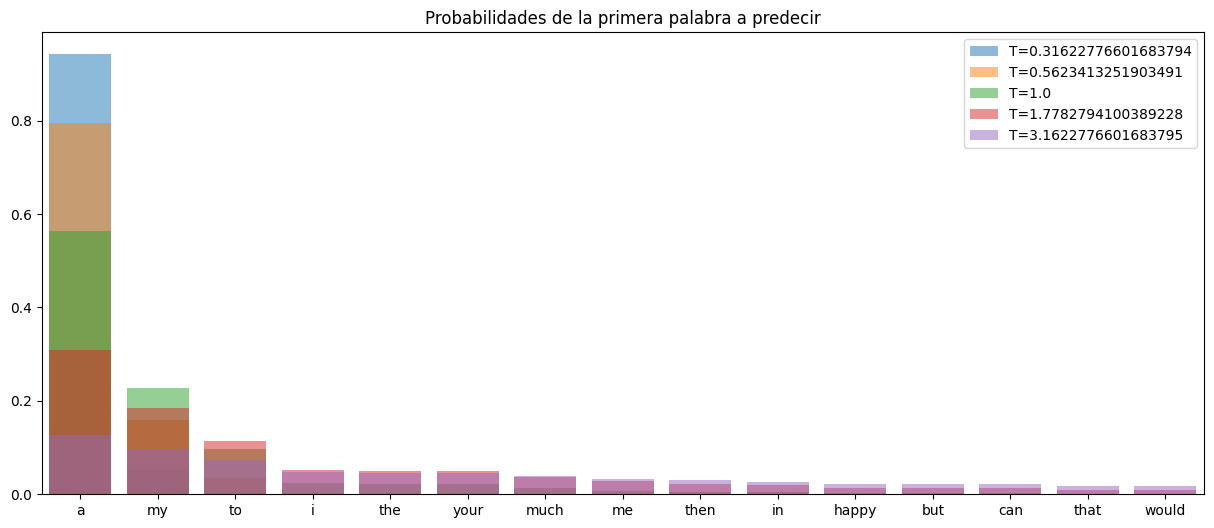

In [ ]:
window_size = 1                             # cantidad de palabras por prediccion
n = wSize                                   # cantidad de predicciones (si pongo mas no se por que se rompe, algo con el tipo de datos)
Ts = [10 ** (i/4) for i in range(-2, 3)]    # temperaturas

# Defino texto inicial
greedy_sentence = text_to_word_sequence('Hello, my name is Frankenstein and I am a good monster, so i am not going to kill you and your family')[:wSize]
print(greedy_sentence)

# Defino secuencia asociada al texto
greedy_sequence = [word2idx[word] if word in word2idx else 1 for word in greedy_sentence]
#print(greedy_sequence)

plt.figure(figsize=(15, 6))
xlim = 15
ticks = []

# Utilizo greedy search y T
for t in Ts:
    out = ""
    aux_sequence = greedy_sequence
    for i in range(n):
        predicted = model.predict([aux_sequence], verbose=0)[0]

        if i == 0 and t == 1:
            for t2 in Ts:
                predicted_t = temperature(predicted, t2)
                plt.bar(np.arange(0, len(predicted_t)), sorted(predicted_t, reverse=True), alpha=0.5, label='T='+str(t2))
                ticks = [idx2word[x] for x in np.argsort(predicted_t)[-1:-xlim-1:-1]]

        predicted = temperature(predicted, t)
        next = np.random.choice(list(reverse_dictionary.keys()), size=1, p=predicted[2:]/np.sum(predicted[2:]))[0]
        aux_sequence = list(aux_sequence[1:]) + list([next])
        predicted = idx2word[next]
        out += predicted
        out += ' '

    print('T =', "{:.2f}".format(t), ': ', out)

plt.xlim(-0.5, xlim-0.5)
plt.legend()
plt.xticks(np.arange(0, xlim), ticks[:xlim])
plt.title('Probabilidades de la primera palabra a predecir')
plt.show()

### Beam Search + T

In [ ]:
def stochastic_beam_search(prev_sequence, num_candidates, max_length, t):

    # Realizo la predicción actual
    predicted = model.predict([prev_sequence], verbose=0)
    predicted = temperature(predicted[0], t)

    # Calculo num_candidates a partir de la predicción
    next_s = np.random.choice(list(reverse_dictionary.keys()), size=num_candidates, replace=False, p=predicted[2:]/np.sum(predicted[2:]))
    next_pos_w = [reverse_dictionary[x] for x in next_s]
    next_p = sorted(predicted, reverse=True)[:num_candidates]
    next_w = ''

    if max_length > 1:

        p = np.zeros((num_candidates, max_length-1))    # vector de probabilidades de cada beam
        s = np.zeros((num_candidates, max_length-1))    # id de palabras de cada beam
        w = ['' for x in range(num_candidates)]         # palabras de cada beam
        select_p = np.zeros(num_candidates)
        select_s = np.zeros(num_candidates)

        # Calculo el beam en cada uno de los candidatos recursivamente, si todavía no esta completo el beam
        for i in range(num_candidates):
            #print('Entro con:', reverse_dictionary[prev_sequence[-1]], [reverse_dictionary[x] if x in reverse_dictionary.keys() else 'UNK' for x in list(prev_sequence[1:]) + list([next_s[i]])])
            s[i], p[i] = stochastic_beam_search(list(prev_sequence[1:]) + list([next_s[i]]), num_candidates, max_length-1, t)
            #print(s[i], reverse_dictionary[s[i][0]])
            w[i] = [reverse_dictionary[x] for x in s[i]]
            #print('Salgo con:', reverse_dictionary[prev_sequence[-1]], [next_pos_w[i]], w[i], p[i])
            next_pos_w[i] = [next_pos_w[i]] + w[i]

        #print('next pos:', next_pos_w)

        # Calculo probabilidades
        for j in range(num_candidates):
            select_p[j] = np.random.choice(p[j], size=1, p=p[j]/np.sum(p[j]))[0]
            next_p[j] = next_p[j] * select_p[j]

        # Guardo frase más probable
        idx = np.argmax(next_p)
        next_w = next_pos_w[idx]
        next_p = next_p[idx]
        #print('w:', next_w)
        next_s = [dictionary[x] for x in next_w]
        #print('s:', next_s)

    else:

        next_w = next_pos_w[0]
        next_p = next_p[0]
        next_s = next_s[0]

    # Devuelve la palabra mas probable y su probabilidad condicional
    #print('Fin:', max_length, reverse_dictionary[prev_sequence[-1]], next_w, next_p, next_s)
    return next_s, next_p

In [ ]:
beam_sentence = text_to_word_sequence('Hello, my name is Frankenstein and I am a good monster, so i am not going to kill you and your family')[:wSize]
beam_sequence = [word2idx[word] if word in word2idx else 1 for word in greedy_sentence]
print(beam_sentence)
print('\nPredicciones: ')

# Complejidad O(M^N)
# Parametros
num_candidates = 3    # M
num_predicts = 5      # N
t = 1

# Utilizo greedy search y T
for t in Ts:
    out = ""
    aux_sequence = beam_sequence
    pred_s, pred_p = stochastic_beam_search(beam_sequence, num_candidates, num_predicts, t)
    pred_w = [reverse_dictionary[x] for x in pred_s]
    print('T =', "{:.2f}".format(t), ': ', pred_w)

['hello', 'my', 'name', 'is', 'frankenstein', 'and', 'i', 'am', 'a', 'good', 'monster', 'so', 'i', 'am', 'not', 'going', 'to', 'kill', 'you', 'and']

Predicciones: 
T = 0.10 :  ['a', 'little', 'did', 'it', 'if']
T = 0.32 :  ['a', 'little', 'one', 'thought', 'these']
T = 1.00 :  ['my', 'cousin', 'of', 'home', 'friends']
T = 3.16 :  ['to', 'feel', 'those', 'consolation', 'for']
T = 10.00 :  ['beheld', 'her', 'revenge', 'while', 'thus']
T = 31.62 :  ['companion', 'means', 'cottagers', 'nearly', 'days']
T = 100.00 :  ['whom', 'work', 'also', 'entered', 'half']
